## Ridge Detector

The goal of this project is to implement a Canny-inspired ridge detector. This can be accomplished by following the pipeline: apply a smoothing filter, apply the 3 hessian masks, apply non-maximum suppression and finally apply hysteresis thresholding.

## Imports

The below cell is used to import the necessary libraries and load the test images

In [5]:
# Import needed libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import skimage
import scipy.stats
import ipywidgets as widgets

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load needed images from Google Drive
bike = skimage.io.imread('/content/drive/MyDrive/RidgeDetectorProject/images/bike.tif').astype('float64')
mandrill = skimage.io.imread('/content/drive/MyDrive/RidgeDetectorProject/images/mandrill.tif').astype('float64')
butterfly = skimage.io.imread('/content/drive/MyDrive/RidgeDetectorProject/images/butterfly.tif').astype('float64')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Function to display multiple images
def display_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    if num_images == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

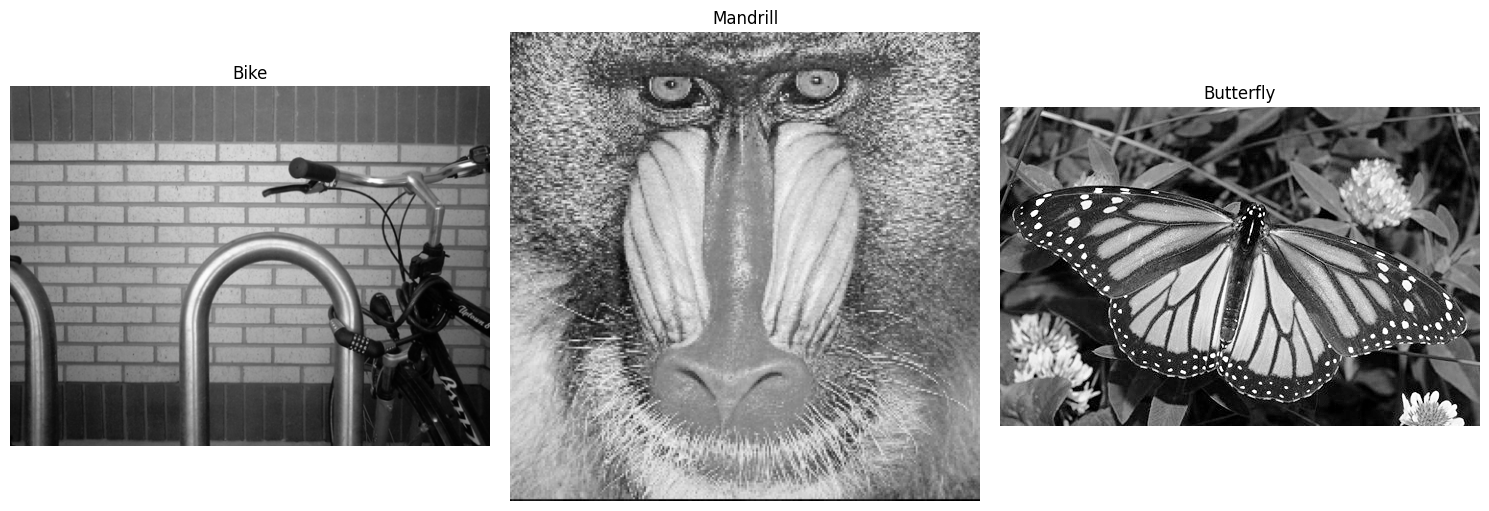

In [7]:
# Display the original images
image_list = [bike, mandrill, butterfly]
titles = ["Bike", "Mandrill", "Butterfly"]
display_images(image_list, titles)

## Step 1: Apply Gaussian Smoothing

The first step to a Canny-Like Ridge Detector is to smooth the image using a gaussian filter. The below function convolves a gaussian mask with the original image and outputs the smoothed image. The purpose of smoothing the image prior to apply the hessian mask is to lower the amount of noise in the image and make the hessian mask more effective at detecting the ridges in the image.

In [8]:
# Function to convolve image with gaussian mask
def smoothFilter(img):
    output = img.copy()

    gaussian = [[0,1,2,1,0],
                 [1,2,4,2,1],
                 [2,4,8,4,2],
                 [1,2,4,2,1],
                 [0,1,2,1,0]]

    # Convolution
    output = ndi.convolve(output, gaussian)

    return output

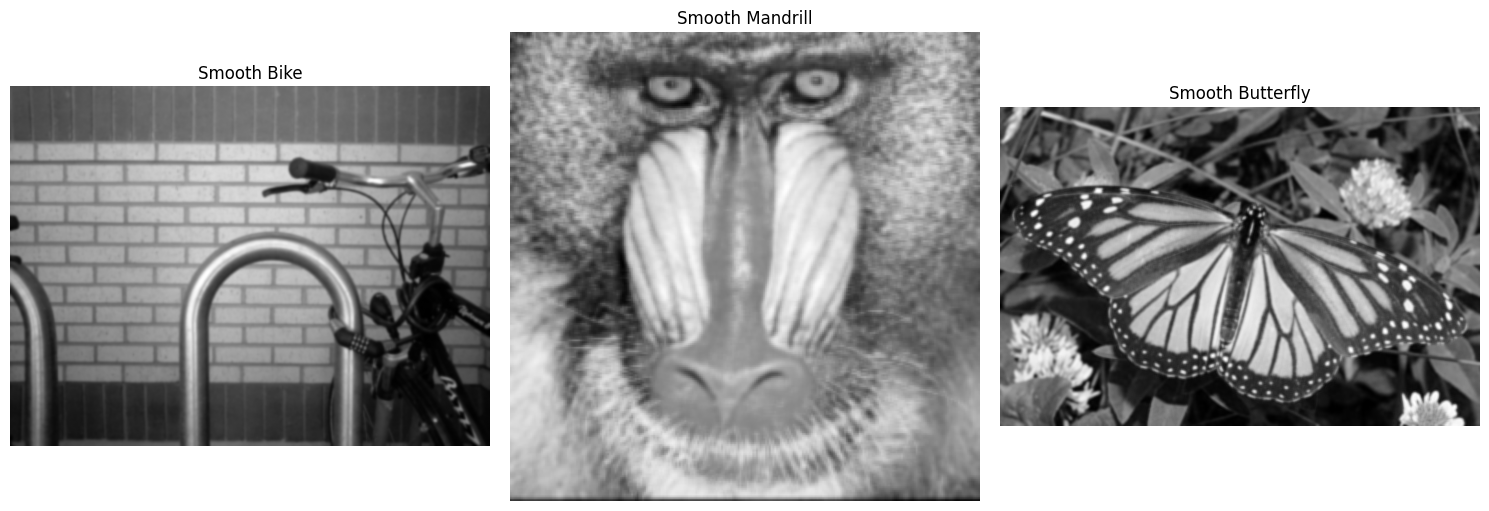

In [9]:
# Call smooth function
bike_smooth = smoothFilter(bike)
mandrill_smooth = smoothFilter(mandrill)
butterfly_smooth = smoothFilter(butterfly)

# Display the blurred images
image_list = [bike_smooth, mandrill_smooth, butterfly_smooth]
titles = ["Smooth Bike", "Smooth Mandrill", "Smooth Butterfly"]
display_images(image_list, titles)

## Step 2: Apply the Hessian masks

The next step is to apply the hessian masks to the blurred images. The hessian mask is the second-order partial derivative of the images. While the smoothing pre-processes the image, the hessian mask extracts the ridges in the image. This can be accomplished by convolving the smoothed imaged to each Hessian mask ($\frac{\partial^2}{\partial x^2}, \quad \frac{\partial^2}{\partial x \partial y}, \quad \frac{\partial^2}{\partial y^2}$). This produces three output images that correspond to each convolved mask.

In [10]:
def hessianFilter(img):
    Hxx_output = img.copy()
    Hxy_output = img.copy()
    Hyy_output = img.copy()

    # d^2/dx^2 (where d is partial derivative)
    Hxx = (1/6) * np.array([[1,-2,1],
                   [4,-8,4],
                   [1,-2,1]])
    # d^2/dxdy
    Hxy = (1/4) * np.array([[1,0,-1],
                   [0,0,0],
                   [-1,0,1]])
    # d^2/dy^2
    Hyy = (1/6) * np.array([[1,4,1],
                   [-2,-8,-2],
                   [1,4,1]])

    # convolve the mask with the input image
    Hxx_output = ndi.convolve(Hxx_output, Hxx)
    Hxy_output = ndi.convolve(Hxy_output, Hxy)
    Hyy_output = ndi.convolve(Hyy_output, Hyy)

    return Hxx_output, Hxy_output, Hyy_output

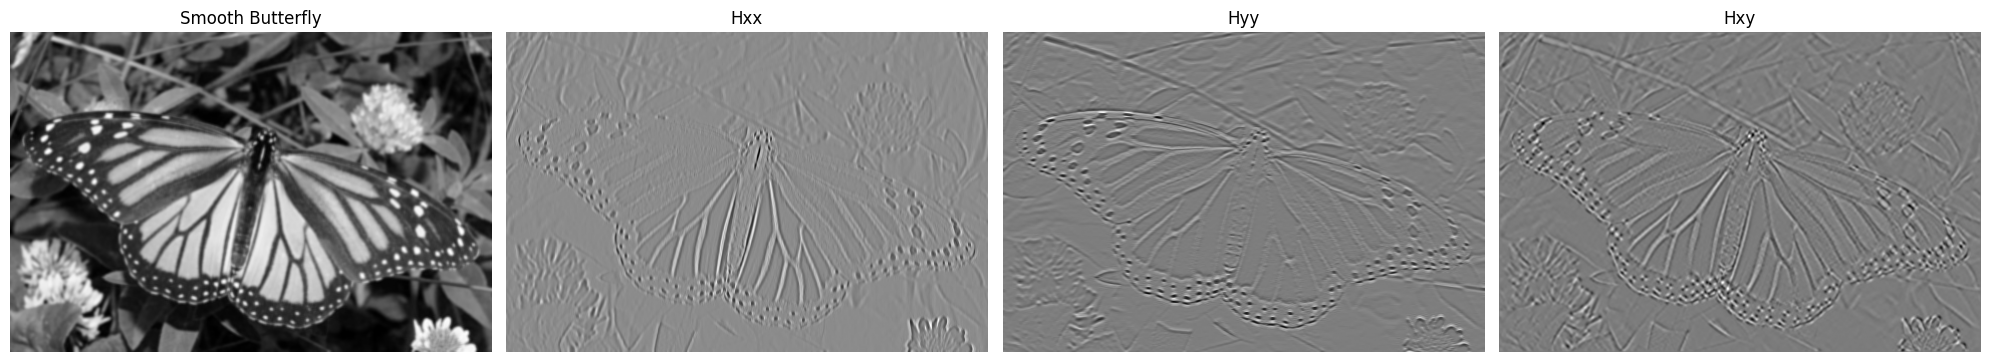

In [11]:
# Display smoothed butterfly and corresponding hessian outputs
Hxx, Hxy, Hyy = hessianFilter(butterfly_smooth)
display_images([butterfly_smooth, Hxx, Hyy, Hxy], ['Smooth Butterfly', 'Hxx', 'Hyy', 'Hxy'])

The next part of the hessian step is to combine the three partial derivative images into a single image that displays the strength of the ridge at each pixel. This can be done by treating the three outputs: Hxx, Hxy, and Hyy as a Hessian matrix. The Hessian matrix is equal to:

$$
    \mathbf{H} = \left[ \begin{array}{cc} H_{xx} & H_{xy} \\ H_{xy} & H_{yy}\end{array} \right]\,.
$$

The eigenvalues of the Hessian matrix can then be used to extract the strength of the matrix at each pixel. The eigenvalues can be calculated by using the formula (where tr() is the trace of the 2x2 Hessian matrix and det() is the determinant):
$
\lambda_{1,2} = \frac{tr(H) \pm \sqrt{tr(H)^2 - 4det(H)}}{2}
$
Since the Hessian matrix is 2x2 and symmetric, the eigenvalue formula will produce two real eigenvalues. The eigenvalues can then be assigned $\lambda_{min}$ or $\lambda_{max}$ depending on their value and can be plugged into the following equation to get the corresponding ridge strength image:
$
g(\mathbf{x}) = \sqrt{|\lambda_{min}|} \cdot \sqrt{|\lambda_{max} - \lambda_{min}|}
$


In [12]:
def hessianEigenvalues(Hxx, Hxy, Hyy):
    # calculate the trace
    trace = Hxx + Hyy
    # calculate determinant
    det = Hxx * Hyy - Hxy ** 2

    # calculate the two eigenvalues
    evalmin = (trace + np.sqrt(trace**2 - 4 * det)) / 2
    evalmax = (trace - np.sqrt(trace**2 - 4 * det)) / 2

    # Since H matrix is symmetric and real the eigenvalues will also be real. So the "+" eigenvalues will correspond to the max and the "-" will correspond to the min
    output = np.sqrt(np.abs(evalmin)) * np.sqrt(np.abs(evalmax - evalmin))

    return output

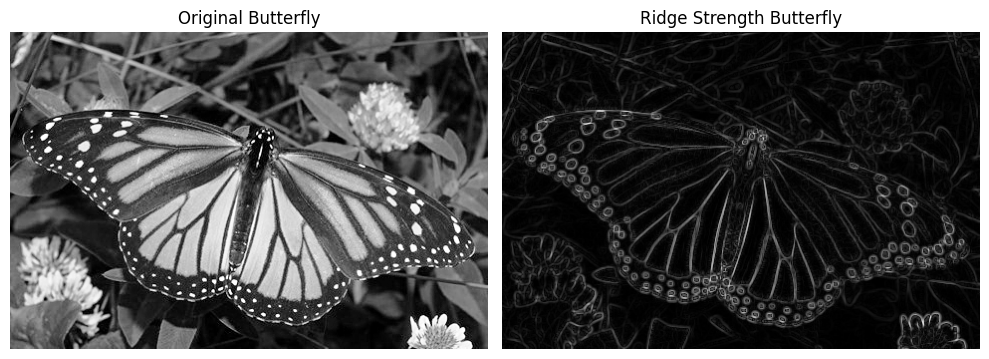

In [13]:
# Display the original butterfly and the ridge strength image of the butterfly
Hxx, Hxy, Hyy = hessianFilter(butterfly_smooth)
butterfly_hessian = hessianEigenvalues(Hxx, Hxy, Hyy)

# display smoothed butterfly and butterfly with hessian applied
display_images([butterfly, butterfly_hessian], ['Original Butterfly', 'Ridge Strength Butterfly'])

## Step 3: Apply Non-maximum suppression (NMS)

The next step is to apply non-maximum suppression to the ridge strength image. Non-maximum suppression is used in object detection to refine the image and increase the accuracy of the model. Non-maximum suppression uses the angle and ridge strength at each pixel to determine the strongest path of the ridge. The angle theta (the direction perpindicular to the ridge) is calculated by using the orientation equation: $$\theta = \frac{1}{2} arctan(\frac{2H_{xy}}{H_{xx} - H_{yy}})$$

The non-maxium suppression algorithm then uses the theta to extract the forward and backward pixels that are perpendicular to the ridge. The central pixel is then compared to the forward and backward pixel and if the ridge strength of either pixel is bigger, the ridge strength of the central pixel is set to 0. If the ridge strength of the central pixel is bigger, the ridge strength stays the same.

In [14]:
def hessianTheta(Hxx, Hxy, Hyy):

    theta = (1/2)*np.arctan2(2*Hxy, Hxx - Hyy)
    return theta

def nonMaximumSuppression(g, theta):

    output = np.zeros_like(g)

    # u_min rounded to the nearest integer
    u_minx = np.round(np.cos(theta)).astype(int)
    u_miny = np.round(np.sin(theta)).astype(int)

    # loop through all pixels
    for y in range(0, g.shape[0]-1):        # rows
        for x in range(0, g.shape[1]-1):    # cols

            # neighboring pixels in the x direction
            xn_forward = x + u_minx[y,x]
            xn_backward = x - u_minx[y,x]

            # neighboring pixels in the y direction
            yn_forward = y + u_miny[y,x]
            yn_backward = y - u_miny[y,x]

            # check bounds
            if (0 <= xn_forward < g.shape[1] and 0 <= yn_forward < g.shape[0] and
                0 <= xn_backward < g.shape[1] and 0 <= yn_backward < g.shape[0]):

                # update output if current pixel is greater than the pixels in the forward and backwards direction
                if (g[y,x] >= g[yn_forward,xn_forward] and g[y,x] >= g[yn_backward,xn_backward]):
                    output[y,x] = g[y,x]
                else:
                    output[y,x] = 0

    return output

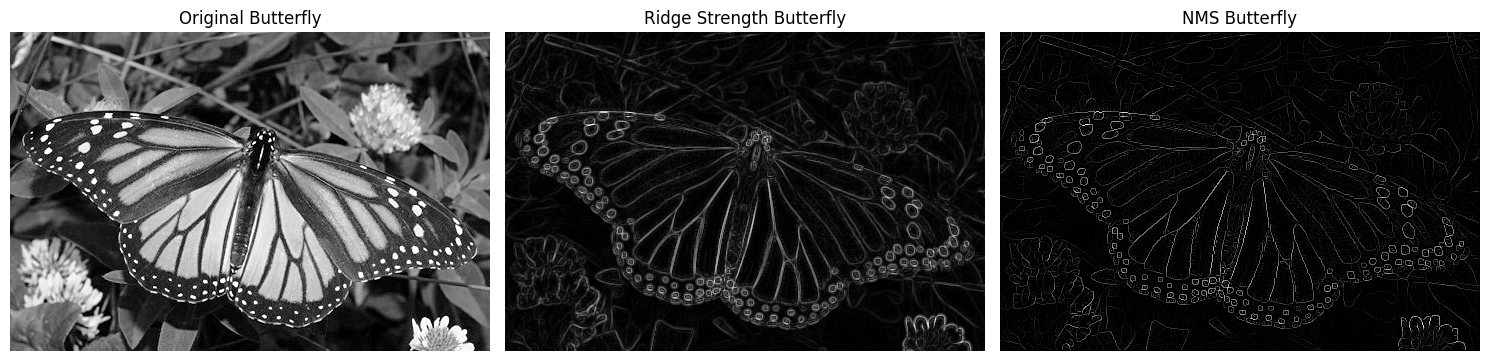

In [15]:
# Display the original butterfly, the ridge strength butterfly, and the non-maximum suppression butterfly
Hxx, Hxy, Hyy = hessianFilter(butterfly_smooth)
butterfly_hessian = hessianEigenvalues(Hxx, Hxy, Hyy)
theta = hessianTheta(Hxx, Hxy, Hyy)
butterfly_nms = nonMaximumSuppression(butterfly_hessian, theta)

display_images([butterfly, butterfly_hessian, butterfly_nms], ['Original Butterfly', 'Ridge Strength Butterfly', 'NMS Butterfly'])

## Step 4: Apply Hysteresis Thresholding

The final step is to apply hysteresis thresholding to the non-maximum suppressed image in order to clearly extract the ridges in the image. This process of thresholding converts the grayscale image into a binary (black or white) image. It accomplishes this by checking each pixel in comparison to a $T_{{low}}$ and $T_{{high}}$ value. If the pixel is between $T_{{low}}$ and $T_{{high}}$ it is marked as $E_{{low}}$ and if the pixel is above $T_{{high}}$ it is marked as $E_{{high}}$. An algorithm is then run to see if there is a path between the $E_{{high}}$ pixels and the $E_{{low}}$ pixels. If an $E_{{low}}$ pixel is connected to a path containing an $E_{{high}}$ pixel, it is used in the final image (pixel is set to 1). If an $E_{{low}}$ pixel is not connected to a path containing an $E_{{high}}$ pixel, it is discarded (pixel is set to 0).

In [16]:
def hysteresisThresholding(img, t_low, t_high):

    # create 0 binary image of size img
    output = np.zeros_like(img, dtype=np.uint8)

    # label the pixels as either Ehigh or Elow based on the given thresholding
    e_high = (img >= t_high)
    e_low = (img >= t_low) & (img < t_high)

    # set e_high bits to 1
    output[e_high] = 1

    # 8-connected neighbors offsets
    neighbors = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]

    # iterate through image max of 1000 times
    for i in range(1000):
        update = False

        # loop through all pixels
        for y in range(0, img.shape[0]-1):        # rows
            for x in range(0, img.shape[1]-1):    # cols

                # if pixel is e_low and not marked 1 yet
                if (e_low[y,x] and output[y,x] == 0):

                    # check neighbors of pixel
                    for y_offset, x_offset in neighbors:

                        # if neighbor is 1
                        if output[y + y_offset, x + x_offset] == 1:
                            output[y,x] = 1
                            update = True
                            break;

        # if no updates after scanning every pixel then break
        if update == False:
            break

    return output

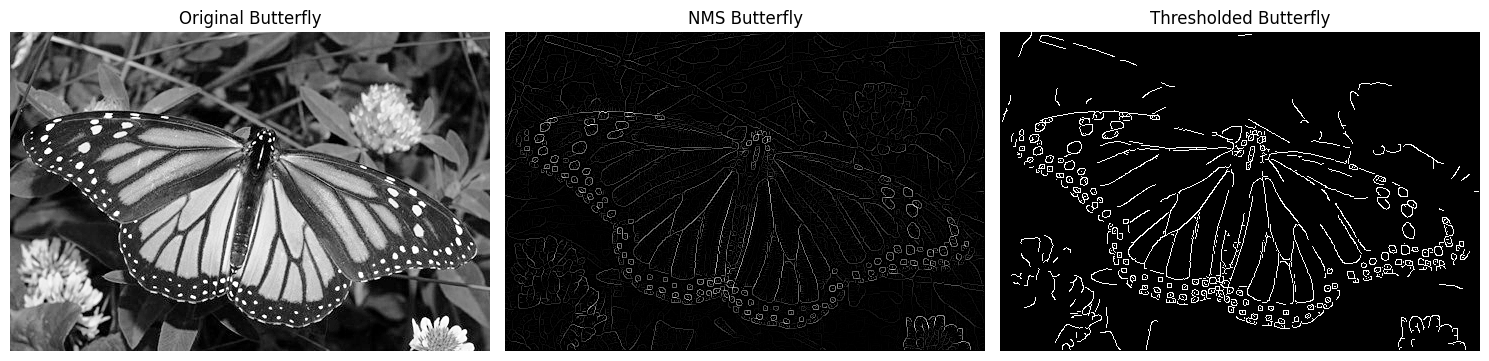

In [17]:
# Display original butterfly, butteryfly with NMS applied, and binary butterfly with hysteresis thresholding
Hxx, Hxy, Hyy = hessianFilter(butterfly_smooth)
butterfly_hessian = hessianEigenvalues(Hxx, Hxy, Hyy)
theta = hessianTheta(Hxx, Hxy, Hyy)
butterfly_nms = nonMaximumSuppression(butterfly_hessian, theta)

# Set low and high thresholds for hysteresis thresholding
t_low = 40 * np.max(butterfly_nms) / 255
t_high = 70 * np.max(butterfly_nms) / 255
butterfly_thresh = hysteresisThresholding(butterfly_nms, t_low, t_high)

display_images([butterfly, butterfly_nms, butterfly_thresh], ['Original Butterfly', 'NMS Butterfly', 'Thresholded Butterfly'])

## Testing the Implementation

With the thresholding done, the Canny-like ridge detector is complete. Below are comparisons between the original images and the ridge detected images

In [34]:
# SET TEST IMAGE (butterfly, mandrill, bike)
test = bike
test_name = "Bike"

# Model pipeline
test_smooth = smoothFilter(test)
Hxx, Hxy, Hyy = hessianFilter(test_smooth)
test_hessian = hessianEigenvalues(Hxx, Hxy, Hyy)
test_theta = hessianTheta(Hxx, Hxy, Hyy)
test_nms = nonMaximumSuppression(test_hessian, test_theta)

# Display widget slider for t_low and t_high
tlow_slider = widgets.IntSlider(value=40, min=0, max=255, step=1, description='TLow', continuous_update=False)
thigh_slider = widgets.IntSlider(value=70, min=0, max=255, step=1, description='THigh', continuous_update=False)

# Create an output widget for plot
out_plot = widgets.Output()

def updateThresh(change):
    # Compute thresholds based on sliders
    t_low = tlow_slider.value * np.max(test_nms) / 255
    t_high = thigh_slider.value * np.max(test_nms) / 255

    # Apply thresholding
    test_thresh = hysteresisThresholding(test_nms, t_low, t_high)

    with out_plot:
        out_plot.clear_output(wait=True)

        # Create a new figure
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Display original image
        axs[0].set_title(f'Original {test_name}')
        axs[0].imshow(test, cmap='gray')

        # Display the ridge detected image
        axs[1].set_title(f'Ridge Detected {test_name}: $T_{{low}}$={tlow_slider.value}, $T_{{high}}$={thigh_slider.value}')
        axs[1].imshow(test_thresh, cmap='gray')

        # remove axis numbers
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        axs[1].set_xticks([])
        axs[1].set_yticks([])

        plt.tight_layout()
        plt.show()

# Observe when sliders changed
tlow_slider.observe(updateThresh, names='value')
thigh_slider.observe(updateThresh, names='value')
display(tlow_slider, thigh_slider, out_plot)

# Trigger initial update
updateThresh(None)

IntSlider(value=40, continuous_update=False, description='TLow', max=255)

IntSlider(value=70, continuous_update=False, description='THigh', max=255)

Output()